# Building change detection

## 1. Data set:

- Data sets from: `https://github.com/S2Looking/Dataset`

- The dataset consists of 5000 bitemporal pairs of very-high-resolutio (VHR) registered images. <br>

- Images are collected from the GaoFen (GF), SuperView (SV) and BeiJing-2 (BJ-2) satellites from 2017 to 2020. <br>

- Each image in the pairs is
 1024 1024 with an image resolution of 0.5 0.8 m/pixels

- The image pairs in the dataset
 are converted from the original TIFF format with 16 bit to PNG format with 8 bit.

- The pairs are accompanied by 65,920 expert-based annotations of changes and two label maps that separately indicate newly built and demolished building regions for each sample in the dataset.

In [2]:
#from google.colab import drive

import zipfile
#import gdown
import os

from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision.transforms.functional import normalize

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2


c:\Users\jango\Anaconda\envs\segm-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#drive.mount('/content/drive')

Check dataset hierarchy:

In [4]:
print('Files structure:')
root_path = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking'
subfolders_1 = os.listdir(root_path)

if '.DS_Store' in subfolders_1:
    subfolders_1.remove('.DS_Store')

subfolders_2 = []
for sub in subfolders_1:
  subfolders_2_i = os.listdir(root_path +'/' +sub)
  if '.DS_Store' in subfolders_2_i:
    subfolders_2_i.remove('.DS_Store')
  subfolders_2.append(subfolders_2_i)

for sub1 in range(len(subfolders_1)):
    print(f'{subfolders_1[sub1]}:')
    for sub2 in range(len(subfolders_2[sub1])):
        file_amount = len(os.listdir(root_path +'/' +subfolders_1[sub1] +'/' +subfolders_2[sub1][sub2]))
        print(f'    {subfolders_2[sub1][sub2]}  ({file_amount} files)')


Files structure:
test:
    Image1  (1000 files)
    Image2  (1000 files)
    label  (1000 files)
    label1  (1000 files)
    label2  (1000 files)
train:
    Image1  (3500 files)
    Image2  (3500 files)
    label  (3500 files)
    label1  (3500 files)
    label2  (3500 files)
val:
    Image1  (500 files)
    Image2  (500 files)
    label  (500 files)
    label1  (500 files)
    label2  (500 files)


Display example of data from S2Looking Dataset

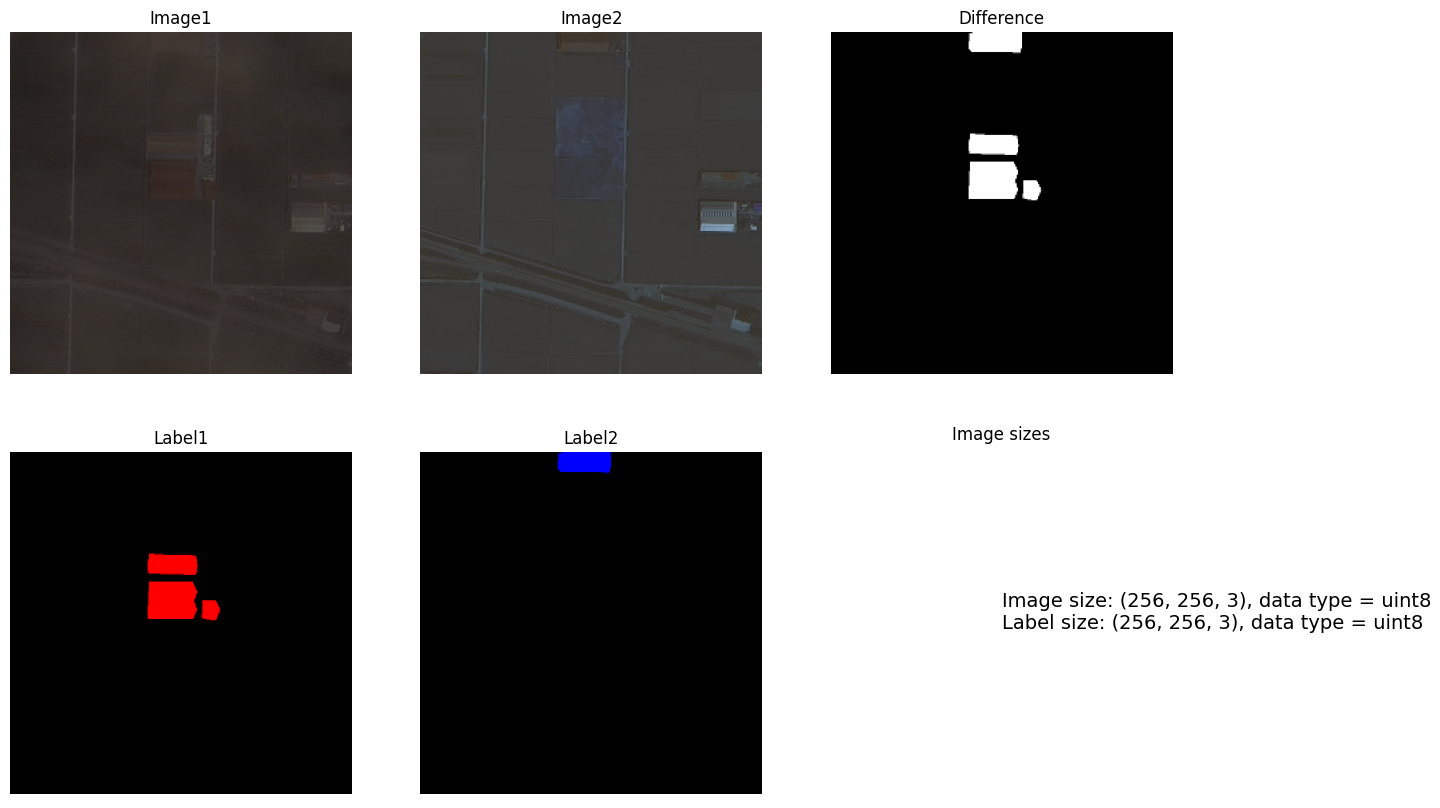

<Figure size 640x480 with 0 Axes>

In [5]:

i = 5

root_path = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking\train'
img1_path = root_path + '/Image1'
lbl1_path = root_path + '/label1'
img2_path = root_path + '/Image2'
lbl2_path = root_path + '/label2'
label_path = root_path + '/label'

img1 = cv2.imread(img1_path +'/'+ os.listdir(img1_path)[i])
lbl1 = cv2.imread(lbl1_path +'/'+os.listdir(lbl1_path)[i])
img2 = cv2.imread(img2_path +'/'+ os.listdir(img2_path)[i])
lbl2 = cv2.imread(lbl2_path +'/'+ os.listdir(lbl2_path)[i])
label = cv2.imread(label_path +'/'+ os.listdir(label_path)[i])

img1 = cv2.resize(img1, (256, 256))
lbl1 = cv2.resize(lbl1, (256, 256))
img2 = cv2.resize(img2, (256, 256))
lbl2 = cv2.resize(lbl2, (256, 256))
label = cv2.resize(label, (256, 256))

txt = f'Image size: {img1.shape}, data type = {img1.dtype}\n'
txt += f'Label size: {label.shape}, data type = {label.dtype}\n'

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img1)
axes[0, 0].set_title('Image1')
axes[0, 0].axis('off')
axes[1, 0].imshow(lbl1)
axes[1, 0].set_title('Label1')
axes[1, 0].axis('off')
axes[0, 1].imshow(img2)
axes[0, 1].set_title('Image2')
axes[0, 1].axis('off')
axes[1, 1].imshow(lbl2)
axes[1, 1].set_title('Label2')
axes[1, 1].axis('off')
axes[0, 2].imshow(label)
axes[0, 2].set_title('Difference')
axes[0, 2].axis('off')
axes[1, 2].axis('off')

axes[1, 2].text(0.5, 0.5, txt, fontsize=14, ha='left', va='center')
axes[1, 2].set_title('Image sizes')
axes[1, 2].axis('off')

plt.figure()
plt.show()



# Data loader:


In [6]:

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),  # jeśli ColorJitter nie działa, usuń tę linię lub zastąp np. A.HueSaturationValue
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], additional_targets={'image0': 'image'})

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], additional_targets={'image0': 'image'})


class S2Looking_DataSet(Dataset):  #Inheriting after DataSet from pytorch - it is required

  def __init__(self, dir1, dir2, dir_mask, augment=None):
        """
        dir1 - directory with images from one period
        dir2 - directory with images from second period
        dir_mask - directory with masks
        transform - idk yet
        """
        self.path_i1 = sorted([os.path.join(dir1, f) for f in os.listdir(dir1) if f.endswith('.png')]) # list of paths to specific image
        self.path_i2 = sorted([os.path.join(dir2, f) for f in os.listdir(dir2) if f.endswith('.png')])
        self.mask_path = sorted([os.path.join(dir_mask, f) for f in os.listdir(dir_mask) if f.endswith('.png')])
        self.augment = augment

            
        # Normalizacja zgodna z ImageNet (dla ResNet)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])




  def __len__(self):
        return len(self.mask_path)

  def __getitem__(self, idx):
        # import images
        I1 = cv2.imread(self.path_i1[idx])
        I2 = cv2.imread(self.path_i2[idx])
        M = cv2.imread(self.mask_path[idx])

        # resize
        I1 = cv2.resize(I1, (256, 256))
        I2 = cv2.resize(I2, (256, 256))
        M = cv2.resize(M, (256, 256))

        # normalize
        I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
        I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)
       
        M = cv2.cvtColor(M, cv2.COLOR_BGR2GRAY)
        _, M = cv2.threshold(M, 127, 255, cv2.THRESH_BINARY)
        M = M.astype(np.float32) / 255.0

        #  # Augmentacje (opcjonalnie)
        if self.augment:
            augmented = self.augment(image=I1, image0=I2, mask=M)
            I1 = augmented['image']
            I2 = augmented['image0']
            M = augmented['mask']
        else:
            # Konwersja do tensorów bez augmentacji
            I1 = torch.from_numpy(I1).permute(2, 0, 1).float() / 255.0
            I2 = torch.from_numpy(I2).permute(2, 0, 1).float() / 255.0
            I1 = self.normalize(I1)
            I2 = self.normalize(I2)
            M = torch.from_numpy(M).unsqueeze(0).float()

        return I1, I2, M







# Siam Unet architecture:

In [7]:


class SiamUnet_diff(nn.Module):
    def __init__(self, n_classes=1):
        super(SiamUnet_diff, self).__init__()

        #  Wczytanie pretrenowanego modelu (ResNet18 z ImageNet)
        self.encoder = models.resnet18(pretrained=True)  # <-- TU są pretrenowane wagi
        self.encoder_layers = list(self.encoder.children())  # rozbijamy na warstwy

        #  Zbieranie warstw encodera (do ekstrakcji cech)
        self.conv1 = nn.Sequential(*self.encoder_layers[:3])  # conv1
        self.conv2 = nn.Sequential(*self.encoder_layers[3:5]) # layer1
        self.conv3 = self.encoder_layers[5]                  # layer2
        self.conv4 = self.encoder_layers[6]                  # layer3
        self.conv5 = self.encoder_layers[7]                  # layer4

        #  Dekoder – "U-Net style upsampling" (trenowany od zera)
        self.up1 = self.up_block(512, 256)
        self.up2 = self.up_block(256, 128)
        self.up3 = self.up_block(128, 64)
        self.up4 = self.up_block(64, 64)
        self.up5 = self.up_block(64, 64)

        #  Finalna warstwa - mapa zmian
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward_once(self, x):
        # Przepuszczenie jednego obrazu przez encoder
        x1 = self.conv1(x)  # 64
        x2 = self.conv2(x1) # 64
        x3 = self.conv3(x2) # 128
        x4 = self.conv4(x3) # 256
        x5 = self.conv5(x4) # 512
        return x1, x2, x3, x4, x5

    def forward(self, x1, x2):
        # Przepuszczenie obu obrazów (before/after)
        f1 = self.forward_once(x1)
        f2 = self.forward_once(x2)

         #  Obliczanie różnicy między cechami
        diff5 = torch.abs(f1[4] - f2[4])  # warstwa 5
        up4 = self.up1(diff5)

        diff4 = torch.abs(f1[3] - f2[3])  # warstwa 4
        up3 = self.up2(up4 + diff4)

        diff3 = torch.abs(f1[2] - f2[2])  # warstwa 3
        up2 = self.up3(up3 + diff3)

        diff2 = torch.abs(f1[1] - f2[1])  # warstwa 2
        up1 = self.up4(up2 + diff2)

        # Finalna mapa zmian
        out = self.up5(up1)
        out = self.final(out)
        return out

    def up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),  # upsampling
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5)
        )


In [8]:
# class EarlyStopping:
#     def __init__(self, patience=3, min_delta=0.0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = float('inf')
#         self.early_stop = False

#     def __call__(self, val_loss):
#         if self.best_loss - val_loss > self.min_delta:
#             self.best_loss = val_loss
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True

In [9]:
root_path = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking'

img1_path_train = os.path.join(root_path, 'train', 'Image1')
img2_path_train = os.path.join(root_path, 'train', 'Image2')
label_path_train = os.path.join(root_path, 'train', 'label')

img1_path_val = os.path.join(root_path, 'val', 'Image1')
img2_path_val = os.path.join(root_path, 'val', 'Image2')
label_path_val = os.path.join(root_path, 'val', 'label')

dataset_train = S2Looking_DataSet(img1_path_train, img2_path_train, label_path_train)
dataset_val = S2Looking_DataSet(img1_path_val, img2_path_val, label_path_val)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=8,
    shuffle=True,
    num_workers=0

)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=8,
    shuffle=False,
    num_workers=0
)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SiamUnet_diff()
model = model.to(device)

criterion = nn.BCEWithLogitsLoss() # Binary cross entropy for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 100

cuda


c:\Users\jango\Anaconda\envs\segm-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jango\Anaconda\envs\segm-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
print("Len dataloader:", len(dataloader_train))

for i, batch in enumerate(dataloader_train):
    print(f"Batch {i}: {[x.shape for x in batch]}")
    if i == 1:
        break  # tylko pierwszy batch, żeby nie zaśmiecać

for batch in dataloader_train:
    img1, img2, masks = batch
    print("Batch loaded.")
    print("Image1:", img1.shape)
    print("Image2:", img2.shape)
    print("Masks:", masks.shape)
    break

print("VAL TEST:", len(dataloader_val))
for batch in dataloader_val:
    print("Walidacja działa! Batch:", [x.shape for x in batch])
    break

Len dataloader: 438
Batch 0: [torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 256, 256])]
Batch 1: [torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 256, 256])]
Batch loaded.
Image1: torch.Size([8, 3, 256, 256])
Image2: torch.Size([8, 3, 256, 256])
Masks: torch.Size([8, 1, 256, 256])
VAL TEST: 63
Walidacja działa! Batch: [torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 256, 256])]


In [12]:
all_train_loss = []
all_val_loss = []



# act_loss_train = 0 
best_loss_train = float('inf')

# act_loss_valid = 0 
best_loss_valid = float('inf')
# early_stopping = EarlyStopping(patience=4, min_delta=0.001)

for epoch in range(epochs):
    if epoch < 5:
        for param in model.encoder.parameters():
            param.requires_grad = False
    else:
        for param in model.encoder.parameters():
            param.requires_grad = True

    train_loss_epoch = 0.0
    val_loss_epoch = 0.0

    # === TRAINING ===
    model.train()

    weights_pth = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking_wagi' # UZUPEŁNIĆ SĆIEŻKĘ DO FOLDERU GDZIE MAJĄ BYĆ ZAPISANE WAGI!!!!

    tloop = tqdm(dataloader_train, desc=f"[Train] Epoch {epoch+1}/{epochs}", unit="batch")
    for img1, img2, masks in tloop:
        img1, img2, masks = img1.to(device), img2.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss_epoch += loss.item() #act_loss_train
        tloop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss_epoch / len(dataloader_train)

    if avg_train_loss < best_loss_train:
        new_name = os.path.join(weights_pth, f'best_weights_train_epoch_{epoch}.pth')
        print(f'[Train] For epoch {epoch}/{epochs}, with loss fcn val = {avg_train_loss} model saved')
        torch.save(model.state_dict(), new_name)
        best_loss_train = avg_train_loss

    all_train_loss.append(avg_train_loss)



    # === VALIDATION ===
    model.eval()
    vloop = tqdm(dataloader_val, desc=f"[Val] Epoch {epoch+1}/{epochs}", unit="batch")
    with torch.no_grad():
        for img1, img2, masks in vloop:
            img1, img2, masks = img1.to(device), img2.to(device), masks.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, masks)

            val_loss_epoch += loss.item()

            vloop.set_postfix(val_loss=loss.item())

    avg_val_loss = val_loss_epoch / len(dataloader_val)

    if avg_val_loss < best_loss_valid:
        new_name = os.path.join(weights_pth, f'best_weights_val_epoch_{epoch}.pth')
        print(f'[Val] For epoch {epoch}/{epochs}, with loss fcn val = {avg_val_loss} model saved')
        torch.save(model.state_dict(), new_name)
        best_loss_valid = avg_val_loss

    all_val_loss.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

    # early_stopping(avg_val_loss)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered.")
    #     break


[Train] Epoch 1/100: 100%|██████████| 438/438 [06:43<00:00,  1.09batch/s, loss=0.255]


[Train] For epoch 0/100, with loss fcn val = 0.44420992545613414 model saved


[Val] Epoch 1/100: 100%|██████████| 63/63 [00:54<00:00,  1.15batch/s, val_loss=0.309]


[Val] For epoch 0/100, with loss fcn val = 0.3215005913424113 model saved
Epoch 1: Train Loss = 0.4442 | Val Loss = 0.3215


[Train] Epoch 2/100: 100%|██████████| 438/438 [04:45<00:00,  1.53batch/s, loss=0.18] 


[Train] For epoch 1/100, with loss fcn val = 0.21155770082179814 model saved


[Val] Epoch 2/100: 100%|██████████| 63/63 [00:41<00:00,  1.51batch/s, val_loss=0.141]


[Val] For epoch 1/100, with loss fcn val = 0.16339011845134555 model saved
Epoch 2: Train Loss = 0.2116 | Val Loss = 0.1634


[Train] Epoch 3/100: 100%|██████████| 438/438 [04:43<00:00,  1.54batch/s, loss=0.139] 


[Train] For epoch 2/100, with loss fcn val = 0.1300578945099491 model saved


[Val] Epoch 3/100: 100%|██████████| 63/63 [00:42<00:00,  1.49batch/s, val_loss=0.0761]


[Val] For epoch 2/100, with loss fcn val = 0.10682330576200334 model saved
Epoch 3: Train Loss = 0.1301 | Val Loss = 0.1068


[Train] Epoch 4/100: 100%|██████████| 438/438 [04:32<00:00,  1.61batch/s, loss=0.0989]


[Train] For epoch 3/100, with loss fcn val = 0.0987949323368399 model saved


[Val] Epoch 4/100: 100%|██████████| 63/63 [00:42<00:00,  1.49batch/s, val_loss=0.0492]


[Val] For epoch 3/100, with loss fcn val = 0.08492032887916716 model saved
Epoch 4: Train Loss = 0.0988 | Val Loss = 0.0849


[Train] Epoch 5/100: 100%|██████████| 438/438 [04:27<00:00,  1.64batch/s, loss=0.0631]


[Train] For epoch 4/100, with loss fcn val = 0.08430783979628728 model saved


[Val] Epoch 5/100: 100%|██████████| 63/63 [00:41<00:00,  1.53batch/s, val_loss=0.037] 


[Val] For epoch 4/100, with loss fcn val = 0.07383714302901238 model saved
Epoch 5: Train Loss = 0.0843 | Val Loss = 0.0738


[Train] Epoch 6/100: 100%|██████████| 438/438 [04:56<00:00,  1.48batch/s, loss=0.0613]


[Train] For epoch 5/100, with loss fcn val = 0.07218750472686607 model saved


[Val] Epoch 6/100: 100%|██████████| 63/63 [00:42<00:00,  1.50batch/s, val_loss=0.0325]


[Val] For epoch 5/100, with loss fcn val = 0.05678923315708599 model saved
Epoch 6: Train Loss = 0.0722 | Val Loss = 0.0568


[Train] Epoch 7/100: 100%|██████████| 438/438 [04:53<00:00,  1.49batch/s, loss=0.0757]


[Train] For epoch 6/100, with loss fcn val = 0.06146057560767757 model saved


[Val] Epoch 7/100: 100%|██████████| 63/63 [00:41<00:00,  1.53batch/s, val_loss=0.0232]


[Val] For epoch 6/100, with loss fcn val = 0.04682642070665246 model saved
Epoch 7: Train Loss = 0.0615 | Val Loss = 0.0468


[Train] Epoch 8/100: 100%|██████████| 438/438 [04:49<00:00,  1.51batch/s, loss=0.0397]


[Train] For epoch 7/100, with loss fcn val = 0.05311893587549255 model saved


[Val] Epoch 8/100: 100%|██████████| 63/63 [00:40<00:00,  1.54batch/s, val_loss=0.0191]


[Val] For epoch 7/100, with loss fcn val = 0.04365461097941512 model saved
Epoch 8: Train Loss = 0.0531 | Val Loss = 0.0437


[Train] Epoch 9/100: 100%|██████████| 438/438 [04:49<00:00,  1.52batch/s, loss=0.0314]


[Train] For epoch 8/100, with loss fcn val = 0.04765770812710262 model saved


[Val] Epoch 9/100: 100%|██████████| 63/63 [00:41<00:00,  1.51batch/s, val_loss=0.0154]


[Val] For epoch 8/100, with loss fcn val = 0.04144078416247216 model saved
Epoch 9: Train Loss = 0.0477 | Val Loss = 0.0414


[Train] Epoch 10/100: 100%|██████████| 438/438 [05:44<00:00,  1.27batch/s, loss=0.0362]


[Train] For epoch 9/100, with loss fcn val = 0.04387437953235216 model saved


[Val] Epoch 10/100: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, val_loss=0.0136]


[Val] For epoch 9/100, with loss fcn val = 0.03972933763667705 model saved
Epoch 10: Train Loss = 0.0439 | Val Loss = 0.0397


[Train] Epoch 11/100: 100%|██████████| 438/438 [06:01<00:00,  1.21batch/s, loss=0.0426]


[Train] For epoch 10/100, with loss fcn val = 0.04023145148573128 model saved


[Val] Epoch 11/100: 100%|██████████| 63/63 [00:52<00:00,  1.20batch/s, val_loss=0.0124]


Epoch 11: Train Loss = 0.0402 | Val Loss = 0.0398


[Train] Epoch 12/100: 100%|██████████| 438/438 [05:51<00:00,  1.25batch/s, loss=0.0334]


[Train] For epoch 11/100, with loss fcn val = 0.038244322894915056 model saved


[Val] Epoch 12/100: 100%|██████████| 63/63 [00:45<00:00,  1.39batch/s, val_loss=0.0141]


[Val] For epoch 11/100, with loss fcn val = 0.03925062874184242 model saved
Epoch 12: Train Loss = 0.0382 | Val Loss = 0.0393


[Train] Epoch 13/100: 100%|██████████| 438/438 [05:45<00:00,  1.27batch/s, loss=0.0495]


[Train] For epoch 12/100, with loss fcn val = 0.03539785629640159 model saved


[Val] Epoch 13/100: 100%|██████████| 63/63 [00:43<00:00,  1.43batch/s, val_loss=0.0126]


[Val] For epoch 12/100, with loss fcn val = 0.03820717272659143 model saved
Epoch 13: Train Loss = 0.0354 | Val Loss = 0.0382


[Train] Epoch 14/100: 100%|██████████| 438/438 [05:36<00:00,  1.30batch/s, loss=0.0359]


[Train] For epoch 13/100, with loss fcn val = 0.03389414911026552 model saved


[Val] Epoch 14/100: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s, val_loss=0.0116]


Epoch 14: Train Loss = 0.0339 | Val Loss = 0.0394


[Train] Epoch 15/100: 100%|██████████| 438/438 [05:22<00:00,  1.36batch/s, loss=0.0243]


[Train] For epoch 14/100, with loss fcn val = 0.03170557782377146 model saved


[Val] Epoch 15/100: 100%|██████████| 63/63 [00:44<00:00,  1.41batch/s, val_loss=0.0116]


Epoch 15: Train Loss = 0.0317 | Val Loss = 0.0383


[Train] Epoch 16/100: 100%|██████████| 438/438 [05:30<00:00,  1.33batch/s, loss=0.0271]


[Train] For epoch 15/100, with loss fcn val = 0.030365321289781973 model saved


[Val] Epoch 16/100: 100%|██████████| 63/63 [00:42<00:00,  1.47batch/s, val_loss=0.0115]


Epoch 16: Train Loss = 0.0304 | Val Loss = 0.0396


[Train] Epoch 17/100: 100%|██████████| 438/438 [05:28<00:00,  1.33batch/s, loss=0.0186]


[Train] For epoch 16/100, with loss fcn val = 0.028903453791573577 model saved


[Val] Epoch 17/100: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, val_loss=0.0114]


Epoch 17: Train Loss = 0.0289 | Val Loss = 0.0401


[Train] Epoch 18/100: 100%|██████████| 438/438 [05:30<00:00,  1.32batch/s, loss=0.0408]


[Train] For epoch 17/100, with loss fcn val = 0.027457194351782538 model saved


[Val] Epoch 18/100: 100%|██████████| 63/63 [00:44<00:00,  1.42batch/s, val_loss=0.0115]


Epoch 18: Train Loss = 0.0275 | Val Loss = 0.0410


[Train] Epoch 19/100: 100%|██████████| 438/438 [05:17<00:00,  1.38batch/s, loss=0.0309]


[Train] For epoch 18/100, with loss fcn val = 0.0264433808794849 model saved


[Val] Epoch 19/100: 100%|██████████| 63/63 [00:40<00:00,  1.55batch/s, val_loss=0.0119]


Epoch 19: Train Loss = 0.0264 | Val Loss = 0.0409


[Train] Epoch 20/100: 100%|██████████| 438/438 [05:24<00:00,  1.35batch/s, loss=0.24]  


[Train] For epoch 19/100, with loss fcn val = 0.02558091967940739 model saved


[Val] Epoch 20/100: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s, val_loss=0.0122]


Epoch 20: Train Loss = 0.0256 | Val Loss = 0.0428


[Train] Epoch 21/100: 100%|██████████| 438/438 [05:35<00:00,  1.30batch/s, loss=0.0211]


[Train] For epoch 20/100, with loss fcn val = 0.024557492364044874 model saved


[Val] Epoch 21/100: 100%|██████████| 63/63 [00:44<00:00,  1.40batch/s, val_loss=0.0109]


Epoch 21: Train Loss = 0.0246 | Val Loss = 0.0412


[Train] Epoch 22/100: 100%|██████████| 438/438 [05:33<00:00,  1.31batch/s, loss=0.0242] 


[Train] For epoch 21/100, with loss fcn val = 0.023394791677287998 model saved


[Val] Epoch 22/100: 100%|██████████| 63/63 [00:44<00:00,  1.43batch/s, val_loss=0.0127]


Epoch 22: Train Loss = 0.0234 | Val Loss = 0.0438


[Train] Epoch 23/100: 100%|██████████| 438/438 [05:31<00:00,  1.32batch/s, loss=0.0163] 


[Train] For epoch 22/100, with loss fcn val = 0.02266870866227708 model saved


[Val] Epoch 23/100: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, val_loss=0.0124]


Epoch 23: Train Loss = 0.0227 | Val Loss = 0.0429


[Train] Epoch 24/100: 100%|██████████| 438/438 [05:27<00:00,  1.34batch/s, loss=0.0228] 


[Train] For epoch 23/100, with loss fcn val = 0.02202475709270805 model saved


[Val] Epoch 24/100: 100%|██████████| 63/63 [00:41<00:00,  1.51batch/s, val_loss=0.0127]


Epoch 24: Train Loss = 0.0220 | Val Loss = 0.0438


[Train] Epoch 25/100: 100%|██████████| 438/438 [05:17<00:00,  1.38batch/s, loss=0.0356] 


[Train] For epoch 24/100, with loss fcn val = 0.02111636355868009 model saved


[Val] Epoch 25/100: 100%|██████████| 63/63 [00:42<00:00,  1.47batch/s, val_loss=0.0133]


Epoch 25: Train Loss = 0.0211 | Val Loss = 0.0450


[Train] Epoch 26/100: 100%|██████████| 438/438 [05:25<00:00,  1.35batch/s, loss=0.0187] 


[Train] For epoch 25/100, with loss fcn val = 0.020666181024793347 model saved


[Val] Epoch 26/100: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, val_loss=0.0144]


Epoch 26: Train Loss = 0.0207 | Val Loss = 0.0446


[Train] Epoch 27/100: 100%|██████████| 438/438 [05:17<00:00,  1.38batch/s, loss=0.0229] 


[Train] For epoch 26/100, with loss fcn val = 0.019665569029790966 model saved


[Val] Epoch 27/100: 100%|██████████| 63/63 [00:47<00:00,  1.32batch/s, val_loss=0.0131]


Epoch 27: Train Loss = 0.0197 | Val Loss = 0.0455


[Train] Epoch 28/100: 100%|██████████| 438/438 [04:49<00:00,  1.51batch/s, loss=0.0201] 


[Train] For epoch 27/100, with loss fcn val = 0.019105339178296665 model saved


[Val] Epoch 28/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0137]


Epoch 28: Train Loss = 0.0191 | Val Loss = 0.0451


[Train] Epoch 29/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.0284] 


[Train] For epoch 28/100, with loss fcn val = 0.01878783282755819 model saved


[Val] Epoch 29/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0143]


Epoch 29: Train Loss = 0.0188 | Val Loss = 0.0477


[Train] Epoch 30/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0195] 


[Train] For epoch 29/100, with loss fcn val = 0.018432325442198274 model saved


[Val] Epoch 30/100: 100%|██████████| 63/63 [00:35<00:00,  1.75batch/s, val_loss=0.015] 


Epoch 30: Train Loss = 0.0184 | Val Loss = 0.0459


[Train] Epoch 31/100: 100%|██████████| 438/438 [04:40<00:00,  1.56batch/s, loss=0.0249] 


[Train] For epoch 30/100, with loss fcn val = 0.017866155838585335 model saved


[Val] Epoch 31/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0172]


Epoch 31: Train Loss = 0.0179 | Val Loss = 0.0508


[Train] Epoch 32/100: 100%|██████████| 438/438 [04:41<00:00,  1.55batch/s, loss=0.0146] 


[Train] For epoch 31/100, with loss fcn val = 0.017426099450663413 model saved


[Val] Epoch 32/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0139]


Epoch 32: Train Loss = 0.0174 | Val Loss = 0.0515


[Train] Epoch 33/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.0151] 


[Train] For epoch 32/100, with loss fcn val = 0.016893073087175414 model saved


[Val] Epoch 33/100: 100%|██████████| 63/63 [00:37<00:00,  1.69batch/s, val_loss=0.0166]


Epoch 33: Train Loss = 0.0169 | Val Loss = 0.0499


[Train] Epoch 34/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.02]   


[Train] For epoch 33/100, with loss fcn val = 0.016626866503520847 model saved


[Val] Epoch 34/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0156]


Epoch 34: Train Loss = 0.0166 | Val Loss = 0.0546


[Train] Epoch 35/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.048]  


[Train] For epoch 34/100, with loss fcn val = 0.01626307934684228 model saved


[Val] Epoch 35/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0168]


Epoch 35: Train Loss = 0.0163 | Val Loss = 0.0542


[Val] Epoch 36/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0151]


Epoch 36: Train Loss = 0.0163 | Val Loss = 0.0527


[Train] Epoch 37/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0669] 


[Train] For epoch 36/100, with loss fcn val = 0.01609872784954602 model saved


[Val] Epoch 37/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0165]


Epoch 37: Train Loss = 0.0161 | Val Loss = 0.0540


[Train] Epoch 38/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.013]  


[Train] For epoch 37/100, with loss fcn val = 0.015603620793934079 model saved


[Val] Epoch 38/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0154]


Epoch 38: Train Loss = 0.0156 | Val Loss = 0.0551


[Train] Epoch 39/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0102] 


[Train] For epoch 38/100, with loss fcn val = 0.015344051608058825 model saved


[Val] Epoch 39/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0151]


Epoch 39: Train Loss = 0.0153 | Val Loss = 0.0596


[Train] Epoch 40/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.012]  


[Train] For epoch 39/100, with loss fcn val = 0.015225487453948076 model saved


[Val] Epoch 40/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0168]


Epoch 40: Train Loss = 0.0152 | Val Loss = 0.0551


[Train] Epoch 41/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.00847]


[Train] For epoch 40/100, with loss fcn val = 0.014883744475095783 model saved


[Val] Epoch 41/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0185]


Epoch 41: Train Loss = 0.0149 | Val Loss = 0.0601


[Train] Epoch 42/100: 100%|██████████| 438/438 [04:40<00:00,  1.56batch/s, loss=0.0178] 


[Train] For epoch 41/100, with loss fcn val = 0.014699994278093587 model saved


[Val] Epoch 42/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0201]


Epoch 42: Train Loss = 0.0147 | Val Loss = 0.0597


[Val] Epoch 43/100: 100%|██████████| 63/63 [00:35<00:00,  1.75batch/s, val_loss=0.0186]


Epoch 43: Train Loss = 0.0147 | Val Loss = 0.0611


[Train] Epoch 44/100: 100%|██████████| 438/438 [04:41<00:00,  1.55batch/s, loss=0.00422]


[Train] For epoch 43/100, with loss fcn val = 0.014377788858505212 model saved


[Val] Epoch 44/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0183]


Epoch 44: Train Loss = 0.0144 | Val Loss = 0.0651


[Val] Epoch 45/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0187]


Epoch 45: Train Loss = 0.0144 | Val Loss = 0.0579


[Train] Epoch 46/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.0248] 


[Train] For epoch 45/100, with loss fcn val = 0.014222969671022403 model saved


[Val] Epoch 46/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0206]


Epoch 46: Train Loss = 0.0142 | Val Loss = 0.0627


[Train] Epoch 47/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.0139] 


[Train] For epoch 46/100, with loss fcn val = 0.014117836034707894 model saved


[Val] Epoch 47/100: 100%|██████████| 63/63 [00:36<00:00,  1.71batch/s, val_loss=0.0208]


Epoch 47: Train Loss = 0.0141 | Val Loss = 0.0600


[Train] Epoch 48/100: 100%|██████████| 438/438 [04:43<00:00,  1.54batch/s, loss=0.0361] 


[Train] For epoch 47/100, with loss fcn val = 0.013976154990332652 model saved


[Val] Epoch 48/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0198]


Epoch 48: Train Loss = 0.0140 | Val Loss = 0.0651


[Train] Epoch 49/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.00795]


[Train] For epoch 48/100, with loss fcn val = 0.013759196264941466 model saved


[Val] Epoch 49/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0193]


Epoch 49: Train Loss = 0.0138 | Val Loss = 0.0624


[Train] Epoch 50/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.00529]


[Train] For epoch 49/100, with loss fcn val = 0.013644664490927164 model saved


[Val] Epoch 50/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0224]


Epoch 50: Train Loss = 0.0136 | Val Loss = 0.0614


[Train] Epoch 51/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.00788]


[Train] For epoch 50/100, with loss fcn val = 0.013450168451660027 model saved


[Val] Epoch 51/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0228]


Epoch 51: Train Loss = 0.0135 | Val Loss = 0.0664


[Train] Epoch 52/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.0188] 


[Train] For epoch 51/100, with loss fcn val = 0.013233387852342774 model saved


[Val] Epoch 52/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0221]


Epoch 52: Train Loss = 0.0132 | Val Loss = 0.0612


[Train] Epoch 53/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.012]  


[Train] For epoch 52/100, with loss fcn val = 0.013173326534180813 model saved


[Val] Epoch 53/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0222]


Epoch 53: Train Loss = 0.0132 | Val Loss = 0.0694


[Train] Epoch 54/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0158] 


[Train] For epoch 53/100, with loss fcn val = 0.012988531914195174 model saved


[Val] Epoch 54/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0231]


Epoch 54: Train Loss = 0.0130 | Val Loss = 0.0686


[Train] Epoch 55/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.0109] 


[Train] For epoch 54/100, with loss fcn val = 0.012834241132137098 model saved


[Val] Epoch 55/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.023] 


Epoch 55: Train Loss = 0.0128 | Val Loss = 0.0651


[Val] Epoch 56/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0221]


Epoch 56: Train Loss = 0.0129 | Val Loss = 0.0675


[Train] Epoch 57/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0288] 


[Train] For epoch 56/100, with loss fcn val = 0.012797651059721431 model saved


[Val] Epoch 57/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0212]


Epoch 57: Train Loss = 0.0128 | Val Loss = 0.0697


[Train] Epoch 58/100: 100%|██████████| 438/438 [04:41<00:00,  1.55batch/s, loss=0.0092] 


[Train] For epoch 57/100, with loss fcn val = 0.012656724614146502 model saved


[Val] Epoch 58/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0205]


Epoch 58: Train Loss = 0.0127 | Val Loss = 0.0668


[Train] Epoch 59/100: 100%|██████████| 438/438 [04:41<00:00,  1.55batch/s, loss=0.0374] 


[Train] For epoch 58/100, with loss fcn val = 0.012529277806191548 model saved


[Val] Epoch 59/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.023] 


Epoch 59: Train Loss = 0.0125 | Val Loss = 0.0687


[Train] Epoch 60/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0238] 


[Train] For epoch 59/100, with loss fcn val = 0.012410993526209163 model saved


[Val] Epoch 60/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0252]


Epoch 60: Train Loss = 0.0124 | Val Loss = 0.0731


[Train] Epoch 61/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.00901]


[Train] For epoch 60/100, with loss fcn val = 0.012341601096867631 model saved


[Val] Epoch 61/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.026] 


Epoch 61: Train Loss = 0.0123 | Val Loss = 0.0711


[Train] Epoch 62/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.012]  


[Train] For epoch 61/100, with loss fcn val = 0.012240434059082237 model saved


[Val] Epoch 62/100: 100%|██████████| 63/63 [00:36<00:00,  1.71batch/s, val_loss=0.0233]


Epoch 62: Train Loss = 0.0122 | Val Loss = 0.0681


[Train] Epoch 63/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.00374]


[Train] For epoch 62/100, with loss fcn val = 0.012223154919851384 model saved


[Val] Epoch 63/100: 100%|██████████| 63/63 [00:36<00:00,  1.71batch/s, val_loss=0.0262]


Epoch 63: Train Loss = 0.0122 | Val Loss = 0.0700


[Train] Epoch 64/100: 100%|██████████| 438/438 [04:45<00:00,  1.54batch/s, loss=0.0255] 


[Train] For epoch 63/100, with loss fcn val = 0.011948232545377049 model saved


[Val] Epoch 64/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0258]


Epoch 64: Train Loss = 0.0119 | Val Loss = 0.0710


[Train] Epoch 65/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.00847]


[Train] For epoch 64/100, with loss fcn val = 0.011885144105648886 model saved


[Val] Epoch 65/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0248]


Epoch 65: Train Loss = 0.0119 | Val Loss = 0.0707


[Train] Epoch 66/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.0132] 


[Train] For epoch 65/100, with loss fcn val = 0.011747329976392664 model saved


[Val] Epoch 66/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0241]


Epoch 66: Train Loss = 0.0117 | Val Loss = 0.0730


[Val] Epoch 67/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0255]


Epoch 67: Train Loss = 0.0118 | Val Loss = 0.0756


[Train] Epoch 68/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.0141] 


[Train] For epoch 67/100, with loss fcn val = 0.011674241654013526 model saved


[Val] Epoch 68/100: 100%|██████████| 63/63 [00:37<00:00,  1.70batch/s, val_loss=0.0245]


Epoch 68: Train Loss = 0.0117 | Val Loss = 0.0717


[Train] Epoch 69/100: 100%|██████████| 438/438 [04:45<00:00,  1.54batch/s, loss=0.0079] 


[Train] For epoch 68/100, with loss fcn val = 0.011641823487318032 model saved


[Val] Epoch 69/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0244]


Epoch 69: Train Loss = 0.0116 | Val Loss = 0.0719


[Train] Epoch 70/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.0186] 


[Train] For epoch 69/100, with loss fcn val = 0.011487699966967004 model saved


[Val] Epoch 70/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0264]


Epoch 70: Train Loss = 0.0115 | Val Loss = 0.0739


[Train] Epoch 71/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.0047] 


[Train] For epoch 70/100, with loss fcn val = 0.011320339888972167 model saved


[Val] Epoch 71/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0244]


Epoch 71: Train Loss = 0.0113 | Val Loss = 0.0709


[Train] Epoch 72/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0119] 


[Train] For epoch 71/100, with loss fcn val = 0.011319789130742487 model saved


[Val] Epoch 72/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0263]


Epoch 72: Train Loss = 0.0113 | Val Loss = 0.0789


[Train] Epoch 73/100: 100%|██████████| 438/438 [04:41<00:00,  1.55batch/s, loss=0.0327] 


[Train] For epoch 72/100, with loss fcn val = 0.011279526157049488 model saved


[Val] Epoch 73/100: 100%|██████████| 63/63 [00:36<00:00,  1.71batch/s, val_loss=0.0249]


Epoch 73: Train Loss = 0.0113 | Val Loss = 0.0796


[Train] Epoch 74/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0111] 


[Train] For epoch 73/100, with loss fcn val = 0.011196617775949646 model saved


[Val] Epoch 74/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0254]


Epoch 74: Train Loss = 0.0112 | Val Loss = 0.0719


[Train] Epoch 75/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.00876]


[Train] For epoch 74/100, with loss fcn val = 0.011160735887173376 model saved


[Val] Epoch 75/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0265]


Epoch 75: Train Loss = 0.0112 | Val Loss = 0.0764


[Train] Epoch 76/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.00399]


[Train] For epoch 75/100, with loss fcn val = 0.010983244265051192 model saved


[Val] Epoch 76/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0254]


Epoch 76: Train Loss = 0.0110 | Val Loss = 0.0790


[Train] Epoch 77/100: 100%|██████████| 438/438 [06:48<00:00,  1.07batch/s, loss=0.0111] 


[Train] For epoch 76/100, with loss fcn val = 0.010979167388786125 model saved


[Val] Epoch 77/100: 100%|██████████| 63/63 [01:02<00:00,  1.00batch/s, val_loss=0.024] 


Epoch 77: Train Loss = 0.0110 | Val Loss = 0.0798


[Train] Epoch 78/100: 100%|██████████| 438/438 [05:16<00:00,  1.38batch/s, loss=0.0172] 


[Train] For epoch 77/100, with loss fcn val = 0.0109088977774367 model saved


[Val] Epoch 78/100: 100%|██████████| 63/63 [00:36<00:00,  1.70batch/s, val_loss=0.0256]


Epoch 78: Train Loss = 0.0109 | Val Loss = 0.0768


[Train] Epoch 79/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.0168] 


[Train] For epoch 78/100, with loss fcn val = 0.010863156702165326 model saved


[Val] Epoch 79/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0283]


Epoch 79: Train Loss = 0.0109 | Val Loss = 0.0768


[Train] Epoch 80/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0143] 


[Train] For epoch 79/100, with loss fcn val = 0.01073315406120361 model saved


[Val] Epoch 80/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0243]


Epoch 80: Train Loss = 0.0107 | Val Loss = 0.0791


[Val] Epoch 81/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.0287]


Epoch 81: Train Loss = 0.0107 | Val Loss = 0.0788


[Train] Epoch 82/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.00893]


[Train] For epoch 81/100, with loss fcn val = 0.01070095369322268 model saved


[Val] Epoch 82/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0259]


Epoch 82: Train Loss = 0.0107 | Val Loss = 0.0801


[Val] Epoch 83/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.027] 


Epoch 83: Train Loss = 0.0108 | Val Loss = 0.0785


[Train] Epoch 84/100: 100%|██████████| 438/438 [04:43<00:00,  1.55batch/s, loss=0.0215] 


[Train] For epoch 83/100, with loss fcn val = 0.01061963982620706 model saved


[Val] Epoch 84/100: 100%|██████████| 63/63 [00:36<00:00,  1.75batch/s, val_loss=0.031] 


Epoch 84: Train Loss = 0.0106 | Val Loss = 0.0789


[Train] Epoch 85/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.00481]


[Train] For epoch 84/100, with loss fcn val = 0.01044944038754967 model saved


[Val] Epoch 85/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0292]


Epoch 85: Train Loss = 0.0104 | Val Loss = 0.0815


[Train] Epoch 86/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.00542]


[Train] For epoch 85/100, with loss fcn val = 0.010411880747734071 model saved


[Val] Epoch 86/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0258]


Epoch 86: Train Loss = 0.0104 | Val Loss = 0.0830


[Val] Epoch 87/100: 100%|██████████| 63/63 [00:36<00:00,  1.72batch/s, val_loss=0.0259]


Epoch 87: Train Loss = 0.0105 | Val Loss = 0.0815


[Train] Epoch 88/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.0116] 


[Train] For epoch 87/100, with loss fcn val = 0.010306336994061764 model saved


[Val] Epoch 88/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0261]


Epoch 88: Train Loss = 0.0103 | Val Loss = 0.0841


[Train] Epoch 89/100: 100%|██████████| 438/438 [04:42<00:00,  1.55batch/s, loss=0.017]  


[Train] For epoch 88/100, with loss fcn val = 0.010139810642733591 model saved


[Val] Epoch 89/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0251]


Epoch 89: Train Loss = 0.0101 | Val Loss = 0.0851


[Val] Epoch 90/100: 100%|██████████| 63/63 [00:35<00:00,  1.76batch/s, val_loss=0.0259]


Epoch 90: Train Loss = 0.0102 | Val Loss = 0.0799


[Train] Epoch 91/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.00899]


[Train] For epoch 90/100, with loss fcn val = 0.010068319569932952 model saved


[Val] Epoch 91/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0261]


Epoch 91: Train Loss = 0.0101 | Val Loss = 0.0860


[Train] Epoch 92/100: 100%|██████████| 438/438 [04:44<00:00,  1.54batch/s, loss=0.00784]


[Train] For epoch 91/100, with loss fcn val = 0.010042223116684892 model saved


[Val] Epoch 92/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0265]


Epoch 92: Train Loss = 0.0100 | Val Loss = 0.0843


[Train] Epoch 93/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.00474]


[Train] For epoch 92/100, with loss fcn val = 0.009898219075262308 model saved


[Val] Epoch 93/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.0257]


Epoch 93: Train Loss = 0.0099 | Val Loss = 0.0834


[Train] Epoch 94/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.00849]


[Train] For epoch 93/100, with loss fcn val = 0.009886789965426303 model saved


[Val] Epoch 94/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.028] 


Epoch 94: Train Loss = 0.0099 | Val Loss = 0.0843


[Val] Epoch 95/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0278]


Epoch 95: Train Loss = 0.0099 | Val Loss = 0.0820


[Val] Epoch 96/100: 100%|██████████| 63/63 [00:36<00:00,  1.73batch/s, val_loss=0.028] 


Epoch 96: Train Loss = 0.0100 | Val Loss = 0.0822


[Train] Epoch 97/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.0145] 


[Train] For epoch 96/100, with loss fcn val = 0.009878242277799676 model saved


[Val] Epoch 97/100: 100%|██████████| 63/63 [00:36<00:00,  1.74batch/s, val_loss=0.0302]


Epoch 97: Train Loss = 0.0099 | Val Loss = 0.0843


[Train] Epoch 98/100: 100%|██████████| 438/438 [04:41<00:00,  1.56batch/s, loss=0.00958]


[Train] For epoch 97/100, with loss fcn val = 0.009724094510635523 model saved


[Val] Epoch 98/100: 100%|██████████| 63/63 [00:35<00:00,  1.75batch/s, val_loss=0.0258]


Epoch 98: Train Loss = 0.0097 | Val Loss = 0.0790


[Train] Epoch 99/100: 100%|██████████| 438/438 [04:41<00:00,  1.55batch/s, loss=0.00409]


[Train] For epoch 98/100, with loss fcn val = 0.009655376530537323 model saved


[Val] Epoch 99/100: 100%|██████████| 63/63 [00:45<00:00,  1.37batch/s, val_loss=0.0296]


Epoch 99: Train Loss = 0.0097 | Val Loss = 0.0841


[Train] Epoch 100/100: 100%|██████████| 438/438 [06:12<00:00,  1.18batch/s, loss=0.00546]


[Train] For epoch 99/100, with loss fcn val = 0.009609464848346022 model saved


[Val] Epoch 100/100: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s, val_loss=0.0276]

Epoch 100: Train Loss = 0.0096 | Val Loss = 0.0839


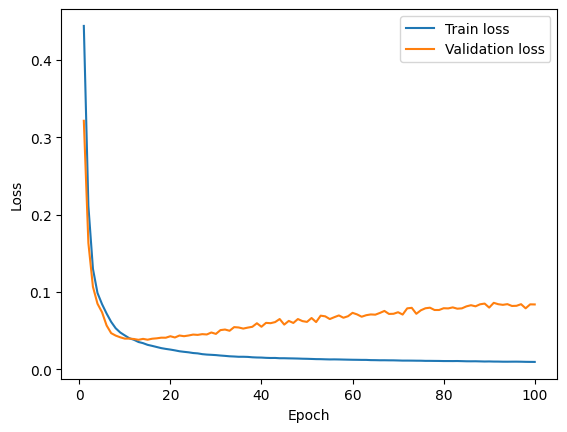

In [13]:
plt.figure()
t = np.linspace(1, epochs, epochs)
plt.plot(t, all_train_loss, label='Train loss')
plt.plot(t, all_val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Save actual trained weights

torch.save(model.state_dict(), r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\model_weights_final_1.pth')

In [15]:
def metricTP(pred, mask):
  return ((pred == 1) & (mask == 1)).sum().item()

def metricFP(pred, mask):
  return ((pred == 1) & (mask == 0)).sum().item()

def metricFN(pred, mask):
  return ((pred == 0) & (mask == 1)).sum().item()

root_path = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking'

img1_path_test = os.path.join(root_path, 'test', 'Image1')
img2_path_test = os.path.join(root_path, 'test', 'Image2')
label_path_test = os.path.join(root_path, 'test', 'label')

dataset_test = S2Looking_DataSet(img1_path_test, img2_path_test, label_path_test)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0)

model.eval()


criterion = nn.BCEWithLogitsLoss()

# all_preds = []
# all_targets = []

correct_pixels = 0
total_pixels = 0
intersection = 0
union = 0

precision_sum = 0
recall_sum = 0


with torch.no_grad():
    dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)
    for img1, img2, masks in dataloader_test:

        img1, img2, masks = img1.to(device), img2.to(device), masks.to(device)
        outputs = model(img1, img2)

        preds = torch.sigmoid(outputs) > 0.5 # Binarisation with sigmoid fcn

        # Accuracy metric:
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        # IoU
        intersection += torch.logical_and(preds, masks).sum().item()
        union += torch.logical_or(preds, masks).sum().item()

        TP = metricTP(preds, masks)
        FN = metricFN(preds, masks)
        FP = metricFP(preds, masks)

        # Precision

        precision_sum += TP / (TP + FN) if (TP + FN) > 0 else 0

        # Recall
        recall_sum += TP / (TP + FP) if (TP + FP) > 0 else 0




Precision = precision_sum / len(dataset_test)
Recall = recall_sum / len(dataset_test)

F1 = 2 / ( (1/Precision) + (1/Recall) )

Accuracy = correct_pixels / total_pixels
iou = intersection / union if union > 0 else 0.0
print(f'Model evaluation:\nAccuracy: {Accuracy}/1\nIoU: {iou}')
print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1: {F1}')




Model evaluation:
Accuracy: 0.9902578582763671/1
IoU: 0.3287688226926793
Precision: 0.3095585088154278
Recall: 0.5619365399507575
F1: 0.3992041896332735
